# Plotting eQTLs, increase font sizes

### Kynon Jade Benjamin and Apuã Paquola

In [1]:
import re
import functools
import subprocess
import numpy as np
import pandas as pd
from plotnine import *
from pandas_plink import read_plink
from warnings import filterwarnings
from matplotlib.cbook import mplDeprecation

filterwarnings("ignore",category=mplDeprecation)
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')

In [2]:
config = {
    'biomart_file': '../_h/biomart.csv',
    'residual_expression_file': '../../_m/genes_residualized_expression.csv',
    'phenotype_file': '/ceph/projects/v3_phase3_paper/inputs/phenotypes/merged/_m/merged_phenotypes.csv',
    'plink_file_prefix': '/ceph/projects/v3_phase3_paper/inputs/genotypes/to_brnum/phase3_plink/_m/phase3',
    'matrixeqtl_output_file': '../../../_m/cis_eqtls_genes.ctxt',
    'gwas_snp_file': '/ceph/projects/v3_phase3_paper/inputs/gwas/PGC2_CLOZUK/map_phase3/_m/libd_hg38_pggc2sz_snps.tsv'
}

In [3]:
@functools.lru_cache()
def get_biomart_df():
    biomart = pd.read_csv(config['biomart_file'])
    biomart['description'] = biomart['description'].str.replace('\[Source.*$','')
    return biomart


@functools.lru_cache()
def get_residual_expression_df():
    residual_expression_df = pd.read_csv(config['residual_expression_file'], index_col=0).transpose()
    return residual_expression_df


@functools.lru_cache()
def get_pheno_df():
    pheno_df = pd.read_csv(config['phenotype_file'], index_col=0)
    return pheno_df


@functools.lru_cache()
def get_expression_and_pheno_df():
    return pd.merge(get_pheno_df(), get_residual_expression_df(), left_index=True, right_index=True)


@functools.lru_cache()
def get_de_df(filename):
    de_df = pd.read_csv(filename, sep='\t', index_col=0, usecols=[0]+list(range(5,13)))
    return de_df


def get_gene_symbol(gene_id, biomart=get_biomart_df()):
    ensge = re.sub('\..+$','', gene_id)
    ggg = biomart[biomart['ensembl_gene_id']==ensge]
    if ggg.shape[0]==0:
        return '', ''
    gs = ggg['external_gene_name'].values[0]
    de = ggg['description'].values[0]
    if type(de)!=str:
        de = ''
    de = re.sub('\[Source:.*$','',de)
    return gs, de



@functools.lru_cache()
def get_gene_id_df():
    return pd.DataFrame({'gene_id': get_residual_expression_df().columns,
                         'ensembl_gene_id': get_residual_expression_df().columns.str.replace('\..+$','')})


@functools.lru_cache()
def gene_info_from_symbol(gene_symbol):
    gene_id_df = get_gene_id_df()
    biomart=get_biomart_df()
    r = biomart[biomart['external_gene_name']==gene_symbol].merge(gene_id_df, on='ensembl_gene_id', how='left')
    return r


@functools.lru_cache()
def gene_id_from_symbol(gene_symbol):
    df = gene_info_from_symbol(gene_symbol)
    assert df.shape[0] == 1
    return df[['gene_id']].iloc[0].values[0]


@functools.lru_cache()
def get_plink_tuple():
    '''
    Usage: (bim, fam, bed) = get_plink_tuple()
    '''
    return read_plink(config['plink_file_prefix'])


@functools.lru_cache()
def get_eqtl_df(fdr=0.05):
    with subprocess.Popen('''awk ' ($6<%f) || (NR==1) {print}' %s ''' % 
                          (fdr, config['matrixeqtl_output_file']),
                          shell=True, stdout=subprocess.PIPE) as p:
        eqtl_df = pd.read_csv(p.stdout, sep='\t')
    return eqtl_df


@functools.lru_cache()
def get_gwas_snps():
    return pd.read_csv(config['gwas_snp_file'], sep='\t', index_col=0)
 
    
def get_gwas_snp(snp_id):
    gwas = get_gwas_snps()
    r = gwas[gwas['our_snp_id']==snp_id]
    assert len(r) == 1
    return r


In [4]:
def letter_snp(number, a0, a1):
    '''
    Example:
    letter_snp(0, 'A', 'G') is 'AA'
    letter_snp(1, 'A', 'G') is 'AG'
    letter_snp(2, 'A', 'G') is 'GG'
    
    '''
    if np.isnan(number):
        return np.nan
    if len(a0)==1 and len(a1)==1:
        sep = ''
    else:
        sep = ' '
    return sep.join(sorted([a0]*int(number) + [a1]*(2-int(number))))


In [5]:
@functools.lru_cache()
def get_snp_df(snp_id):
    '''
    Returns a dataframe containing the genotype on snp snp_id.
    The allele count is the same as in the plink files.
    
    Example: 
    get_snp_df('rs653953').head(5)
    
            rs653953_num rs653953_letter rs653953
    Br5168             0              GG    0\nGG
    Br2582             1              AG    1\nAG
    Br2378             1              AG    1\nAG
    Br5155             2              AA    2\nAA
    Br5182             2              AA    2\nAA
    '''
    (bim, fam, bed) = get_plink_tuple()
    brain_ids = list(set(get_expression_and_pheno_df()['BrNum']).intersection(set(fam['fid'])))
    snp_info = bim[bim['snp']==snp_id]
    snp_pos = snp_info.iloc[0]['i']
    fam_pos = list(fam.set_index('fid').loc[brain_ids]['i'])
    dfsnp = (pd.DataFrame(bed[[snp_pos]].compute()[:,fam_pos], 
                          columns=brain_ids, index=[snp_id + '_num'])
             .transpose().dropna())
    my_letter_snp = functools.partial(letter_snp, a0=snp_info.iloc[0]['a0'], a1=snp_info.iloc[0]['a1'])
    # the 2 - in next line is to workarount a possible bug in pandas_plink? a1 and a0 inverted
    dfsnp[[snp_id + '_num']] = 2 - dfsnp[[snp_id + '_num']].astype('int')
    dfsnp[snp_id + '_letter'] = dfsnp[snp_id + '_num'].apply(my_letter_snp)
    dfsnp[snp_id] = (dfsnp[snp_id + '_num'].astype('str') + '\n' + 
                     dfsnp[snp_id + '_letter'].astype('str')).astype('category')
    return dfsnp

In [6]:
@functools.lru_cache()
def get_gwas_ordered_snp_df(snp_id):
    '''
    Returns a dataframe containing the genotype on snp snp_id.
    The allele count is the number of risk alleles according to GWAS.
    
    Example: 
    get_gwas_ordered_snp_df('rs653953').head(5)
    
            rs653953_num rs653953_letter rs653953
    Br5168             2              GG    2\nGG
    Br2582             1              AG    1\nAG
    Br2378             1              AG    1\nAG
    Br5155             0              AA    0\nAA
    Br5182             0              AA    0\nAA
    '''
    pgc = get_gwas_snps()
    dfsnp = get_snp_df(snp_id).copy()
    gwas_snp = get_gwas_snp(snp_id)
    if gwas_snp['pgc2_a1_same_as_our_counted'].iloc[0]:
        if gwas_snp['OR'].iloc[0] > 1:
            pass
        else:
            dfsnp[[snp_id + '_num']] = 2 - dfsnp[[snp_id + '_num']]
    else:
        if gwas_snp['OR'].iloc[0] > 1:
            dfsnp[[snp_id + '_num']] = 2 - dfsnp[[snp_id + '_num']]
        else:
            pass
    dfsnp[snp_id] = (dfsnp[snp_id + '_num'].astype('str') + '\n' + 
                     dfsnp[snp_id + '_letter'].astype('str')).astype('category')
    
    return dfsnp

In [7]:
@functools.lru_cache()
def get_risk_allele(snp_id):
    gwas_snp = get_gwas_snp(snp_id)
    if gwas_snp['OR'].iloc[0] > 1:
        ra = gwas_snp['A1'].iloc[0]
    else:
        ra = gwas_snp['A2'].iloc[0]
    return ra

In [17]:
def get_snp_gene_pheno_df(snp_id, gene_id, snp_df_func):
    pheno_columns = list(get_pheno_df().columns)
    expr_df = get_expression_and_pheno_df()[pheno_columns + [gene_id]]
    snp_df =  snp_df_func(snp_id)
    return expr_df.merge(snp_df, left_on='BrNum', right_index=True)
    

def simple_snp_expression_plot_impl(snp_id, gene_id, snp_df_func):
    df = get_snp_gene_pheno_df(snp_id, gene_id, snp_df_func)
    y0 = df[gene_id].quantile(.01) - 0.26
    y1 = df[gene_id].quantile(.99) + 0.26
    p = ggplot(df, aes(x=snp_id, y=gene_id)) \
    + geom_boxplot(fill='red', alpha=0.4, outlier_alpha=0) \
    + geom_jitter(width=0.25, stroke=0, alpha=0.6) + ylim(y0, y1) \
    + theme_matplotlib()\
    + theme(axis_text=element_text(size=18), 
            axis_title=element_text(size=21), 
            plot_title=element_text(size=22))
    return p
    

def simple_snp_expression_plot(snp_id, gene_id):
    return simple_snp_expression_plot_impl(snp_id, gene_id, get_snp_df)


def simple_gwas_ordered_snp_expression_plot(snp_id, gene_id):
    return simple_snp_expression_plot_impl(snp_id, gene_id, get_gwas_ordered_snp_df)


def simple_snp_expression_pheno_plot_impl(snp_id, gene_id, snp_df_func, pheno_var):
    df = get_snp_gene_pheno_df(snp_id, gene_id, snp_df_func)
    y0 = df[gene_id].quantile(.01) - 0.26
    y1 = df[gene_id].quantile(.99) + 0.26
    pjd = position_jitterdodge(jitter_width=0.27)
    p = ggplot(df, aes(x=snp_id, y=gene_id, fill=pheno_var)) \
    + geom_boxplot(alpha=0.4, outlier_alpha=0) \
    + geom_jitter(position=pjd, stroke=0, alpha=0.6) + ylim(y0, y1) \
    + theme_matplotlib()\
    + theme(axis_text=element_text(size=18), 
            axis_title=element_text(size=21), 
            plot_title=element_text(size=22))
    return p


In [24]:
def gwas_annotation(snp_id):
    return 'SZ GWAS pvalue: %.1e' % get_gwas_snp(snp_id).iloc[0]['P']


def eqtl_annotation(snp_id, gene_id):
    eqtl_df = get_eqtl_df()
    r = eqtl_df[(eqtl_df['SNP']==snp_id) & (eqtl_df['gene']==gene_id)]
    assert len(r)==1
    return 'eQTL FDR: %.1e' % r.iloc[0]['FDR']


def risk_allele_annotation(snp_id):
    return 'SZ risk allele: %s' % get_risk_allele(snp_id)


def annotated_eqtl_plot(snp_id, gene_id):
    p = simple_snp_expression_plot(snp_id, gene_id)
    gene_symbol, gene_description = get_gene_symbol(gene_id)
    title ="\n".join([gene_symbol,
                     eqtl_annotation(snp_id, gene_id)
                     ])
    p += ggtitle(title) + ylab('Residualized expression') 
    return p


def gwas_annotated_eqtl_plot(snp_id, gene_id):
    p = simple_gwas_ordered_snp_expression_plot(snp_id, gene_id)
    gene_symbol, gene_description = get_gene_symbol(gene_id)
    title ="\n".join([gene_symbol,
                     eqtl_annotation(snp_id, gene_id),
                     gwas_annotation(snp_id),
                     risk_allele_annotation(snp_id)
                     ])
    p += ggtitle(title) + ylab('Residualized expression') 
    return p


def save_plot(p, fn):
    for ext in ['png', 'pdf', 'svg']:
        p.save(fn + '.' + ext)
    

# Top 10 eQTLs

In [13]:
eqtl_df = get_eqtl_df()
eqtl_df.head()

,SNP,gene,beta,t-stat,p-value,FDR
0,rs2165162:74659789:G:C,ENSG00000166435.15,0.617521,76.169005,2.506386e-243,4.234385e-236
1,rs2119028,ENSG00000166435.15,0.617521,76.169005,2.506386e-243,4.234385e-236
2,rs2165163:74660143:G:C,ENSG00000166435.15,0.617521,76.169005,2.506386e-243,4.234385e-236
3,rs12577614:74671100:T:A,ENSG00000166435.15,0.615312,72.682923,1.353998e-235,1.715623e-228
4,rs4944963:74603181:G:A,ENSG00000166435.15,0.612333,70.970053,1.117815e-231,7.081798e-225


top_0_eqtl_caudate 0 rs2165162:74659789:G:C ENSG00000166435.15


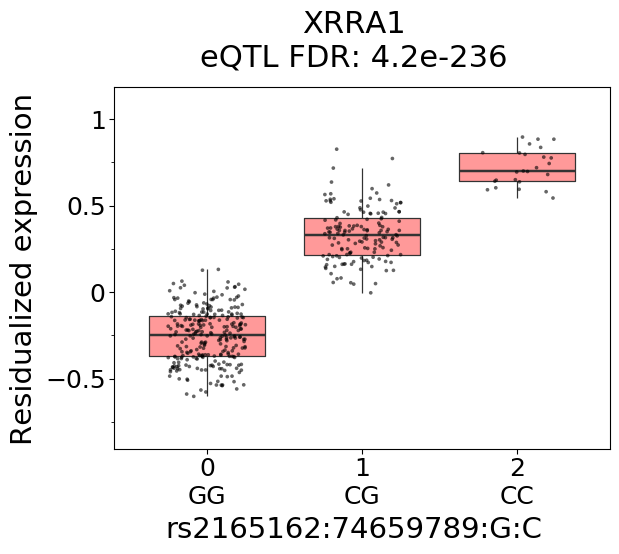

<ggplot: (8774445295553)>
top_1_eqtl_caudate 1 12:56435929:C:G ENSG00000197728.9


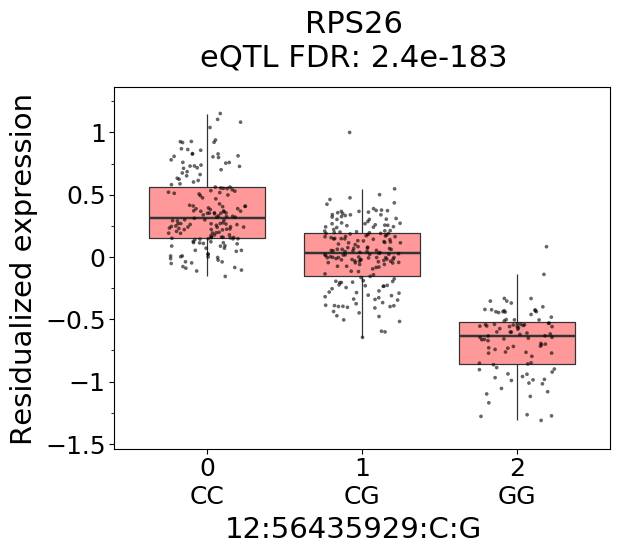

<ggplot: (8774445580316)>
top_2_eqtl_caudate 2 rs2927608:96252432:G:A ENSG00000164308.16


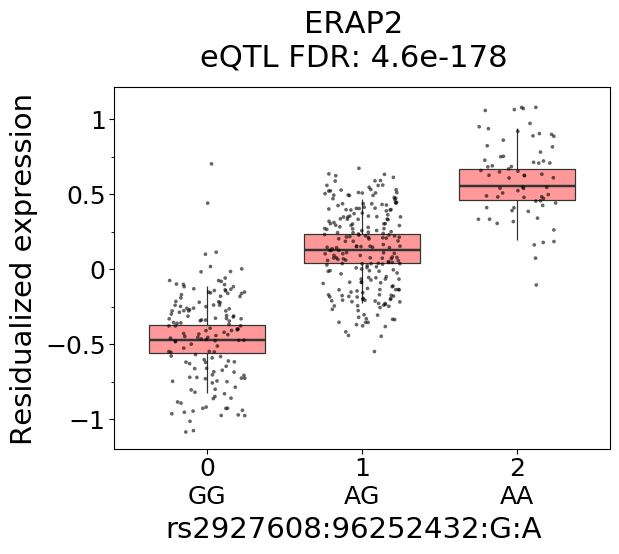

<ggplot: (8774445227406)>
top_3_eqtl_caudate 3 rs147606872:74049336:T:C ENSG00000164346.9


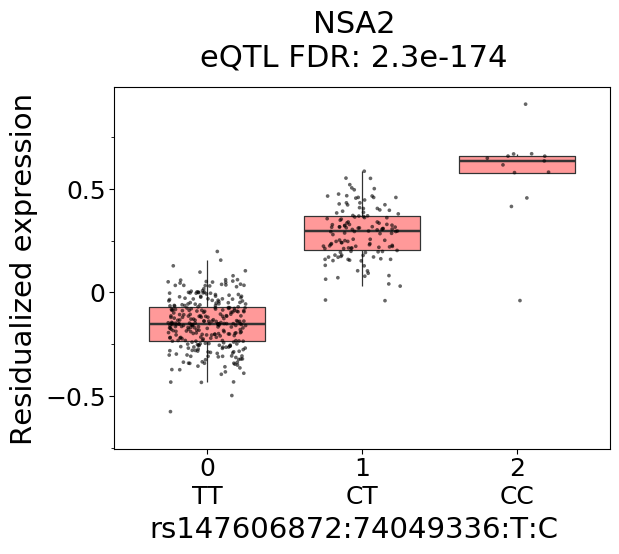

<ggplot: (8774445409699)>
top_4_eqtl_caudate 4 rs5751776:24266954:A:C ENSG00000273295.1


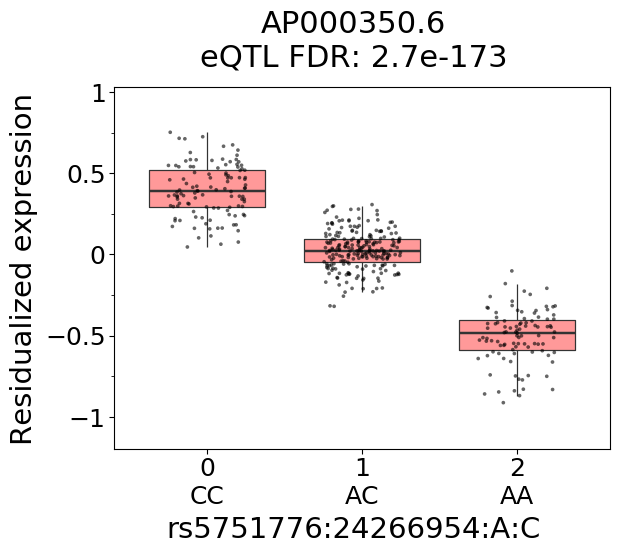

<ggplot: (8774445401122)>
top_5_eqtl_caudate 5 rs12724335:63921882:T:C ENSG00000142856.16


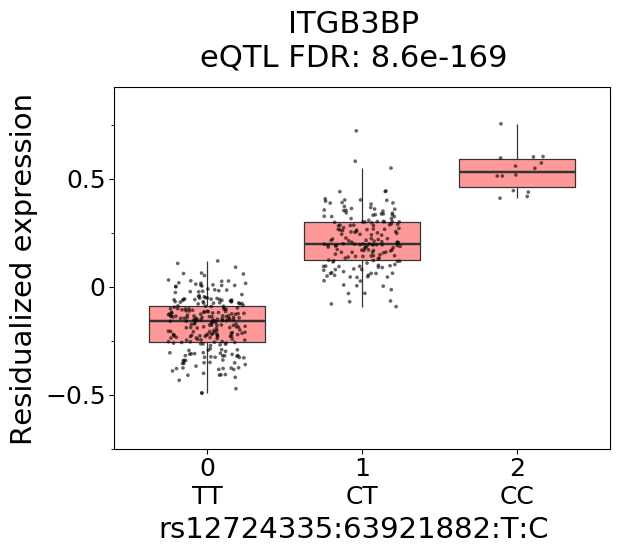

<ggplot: (8774445580373)>
top_6_eqtl_caudate 6 rs3179969 ENSG00000042317.16


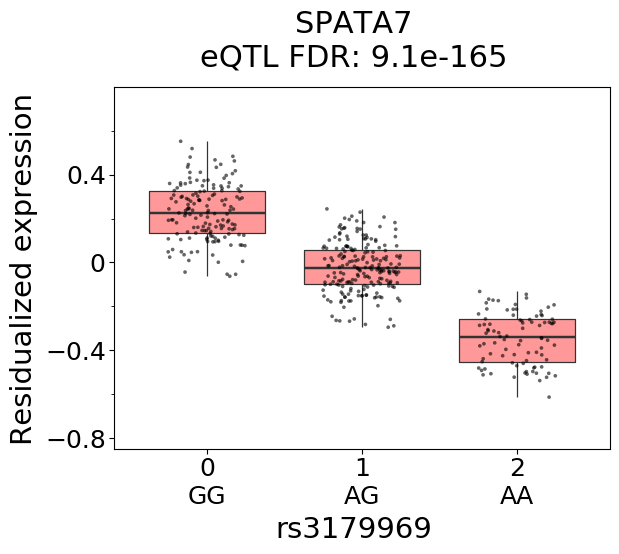

<ggplot: (8774445444419)>
top_7_eqtl_caudate 7 12:9735629:C:G ENSG00000214776.9


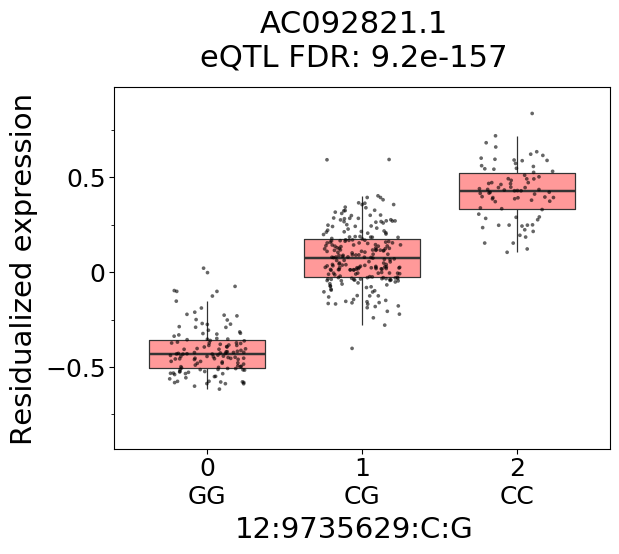

<ggplot: (8774445234095)>
top_8_eqtl_caudate 8 GA030477 ENSG00000244879.5


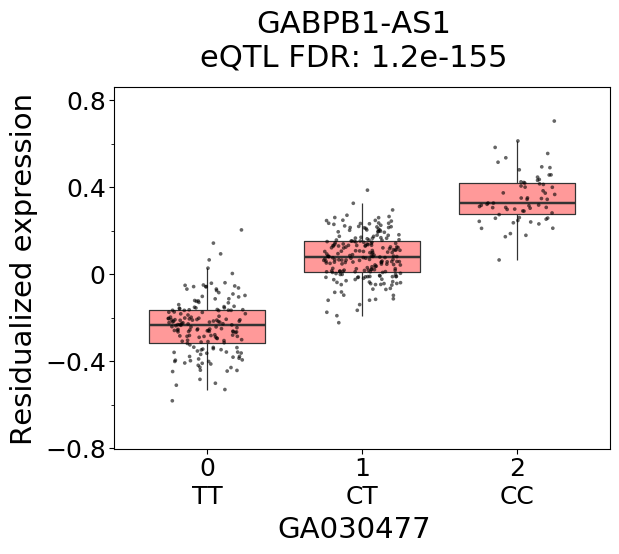

<ggplot: (8774445227481)>
top_9_eqtl_caudate 9 rs10760117 ENSG00000226752.8


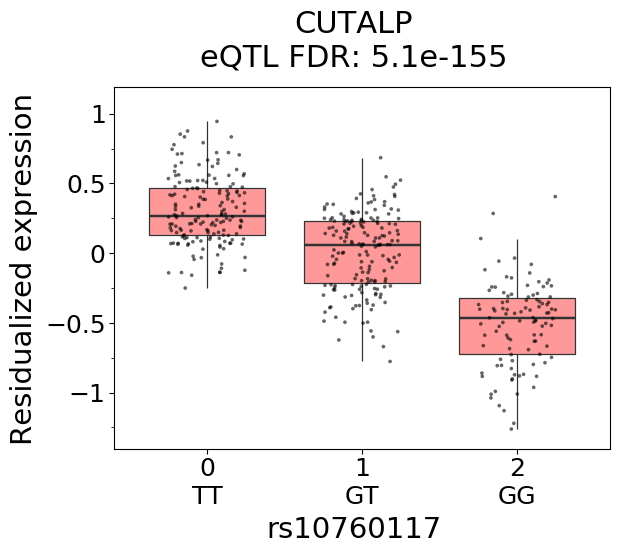

<ggplot: (8774445390939)>


In [18]:
top_10 = eqtl_df.sort_values('p-value', ascending=True).groupby('gene').first().sort_values('p-value').head(10).reset_index()
for x in top_10.itertuples():
    filename = "top_%d_eqtl_caudate" % x.Index
    p = annotated_eqtl_plot(x.SNP, x.gene)
    print(filename, x.Index, x.SNP, x.gene)
    print(p)
    save_plot(p, filename)
    

# Top 10 eQTL with GWAS significant index SNP

In [19]:
gwas_eqtl_df = eqtl_df.merge(get_gwas_snps(), left_on = 'SNP', 
                             right_on = 'our_snp_id', suffixes=['','_gwas'])
print(gwas_eqtl_df.shape)
gwas_eqtl_df.head()

/home/jbenja13/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3242: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/usr/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(1778381, 28)


,SNP,gene,beta,t-stat,p-value,FDR,chrN,our_snp_id,cm,pos,...,A2,OR,SE,P,hg19chrc,hg38chrc,hg38pos,pgc2_a1_same_as_our_counted,rsid,is_index_snp
0,rs2165162:74659789:G:C,ENSG00000166435.15,0.617521,76.169005,2.506386e-243,4.234385e-236,11,rs2165162:74659789:G:C,0,74659789,...,C,1.0245,0.010452,0.0206,chr11,chr11,74948744,False,rs2165162,False
1,rs2165162:74659789:G:C,ENSG00000278879.1,0.390645,35.008290,5.654599e-125,4.443302e-120,11,rs2165162:74659789:G:C,0,74659789,...,C,1.0245,0.010452,0.0206,chr11,chr11,74948744,False,rs2165162,False
2,rs2165162:74659789:G:C,ENSG00000241170.2,-0.230696,-16.074373,2.163145e-45,2.954086e-42,11,rs2165162:74659789:G:C,0,74659789,...,C,1.0245,0.010452,0.0206,chr11,chr11,74948744,False,rs2165162,False
3,rs2165162:74659789:G:C,ENSG00000166439.5,-0.047425,-7.258569,1.991765e-12,3.247074e-10,11,rs2165162:74659789:G:C,0,74659789,...,C,1.0245,0.010452,0.0206,chr11,chr11,74948744,False,rs2165162,False
4,rs2165162:74659789:G:C,ENSG00000242999.3,-0.141998,-5.444231,9.001440e-08,7.280892e-06,11,rs2165162:74659789:G:C,0,74659789,...,C,1.0245,0.010452,0.0206,chr11,chr11,74948744,False,rs2165162,False


In [20]:
top_gwas_eqtl_df = gwas_eqtl_df[(gwas_eqtl_df['P']<5e-8) & 
                                (gwas_eqtl_df['is_index_snp'])].sort_values(['FDR', 'P'])
print(top_gwas_eqtl_df.shape)
top_gwas_eqtl_df.head()

(97, 28)


,SNP,gene,beta,t-stat,p-value,FDR,chrN,our_snp_id,cm,pos,...,A2,OR,SE,P,hg19chrc,hg38chrc,hg38pos,pgc2_a1_same_as_our_counted,rsid,is_index_snp
233170,rs1042992,ENSG00000228451.3,-0.170393,-10.743909,7.050084e-24,3.092319e-21,8,rs1042992,0,26269191,...,T,0.92930,0.012431,3.670000e-09,chr8,chr8,26411675,False,rs1042992,True
274888,rs56145559:73623439:C:T,ENSG00000163016.9,0.139800,9.997511,3.406423e-21,1.242074e-18,2,rs56145559:73623439:C:T,0,73623439,...,T,0.93086,0.011730,1.010000e-09,chr2,chr2,73396311,False,rs56145559,True
365872,rs10083370:104314182:G:A,ENSG00000088808.16,0.059292,8.687367,9.063899e-17,2.345922e-14,14,rs10083370:104314182:G:A,0,104314182,...,A,1.07800,0.009910,3.440000e-14,chr14,chr14,103847845,True,rs10083370,True
387908,rs7432375,ENSG00000114054.13,0.061113,8.447089,5.308962e-16,1.274331e-13,3,rs7432375,0,136288405,...,A,1.07020,0.009784,4.070000e-12,chr3,chr3,136569563,False,rs7432375,True
467667,rs2949006:200715388:T:G,ENSG00000162971.10,-0.058730,-7.692297,1.095257e-13,2.070444e-11,2,rs2949006:200715388:T:G,0,200715388,...,G,1.10530,0.011892,3.690000e-17,chr2,chr2,199850665,True,rs2949006,True


top_0_eqtl_in_gwas_significant_index_snps_caudate 0 rs1042992 ENSG00000228451.3


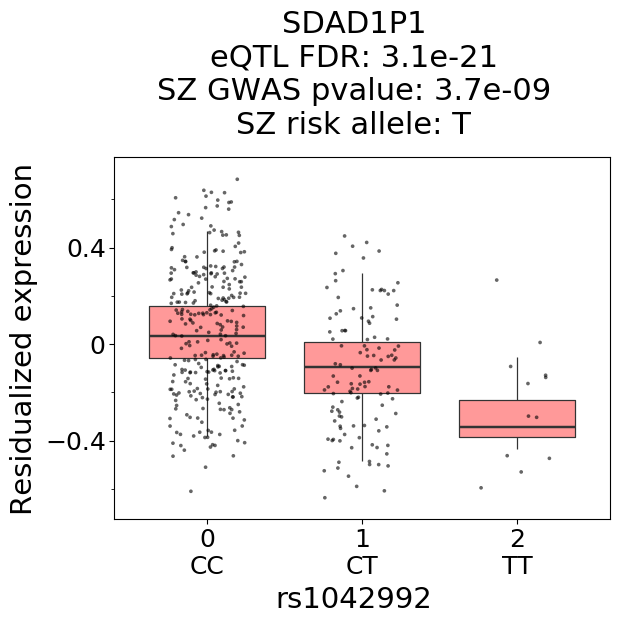

<ggplot: (8774445400619)>
top_1_eqtl_in_gwas_significant_index_snps_caudate 1 rs56145559:73623439:C:T ENSG00000163016.9


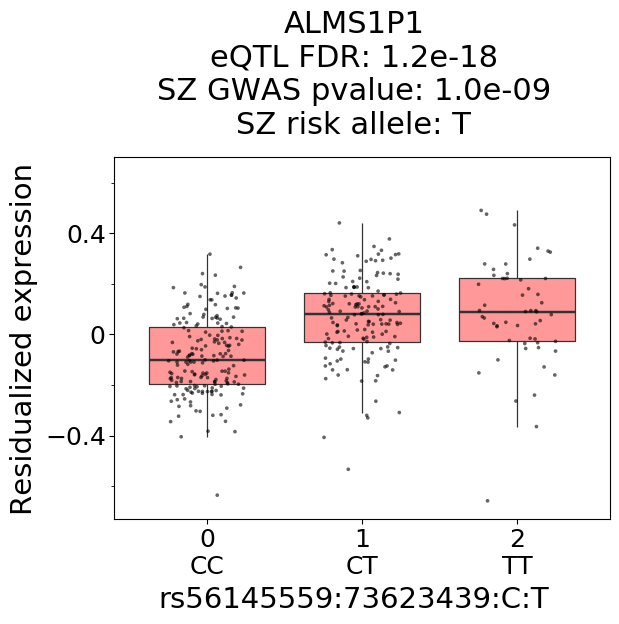

<ggplot: (8774445419864)>
top_2_eqtl_in_gwas_significant_index_snps_caudate 2 rs10083370:104314182:G:A ENSG00000088808.16


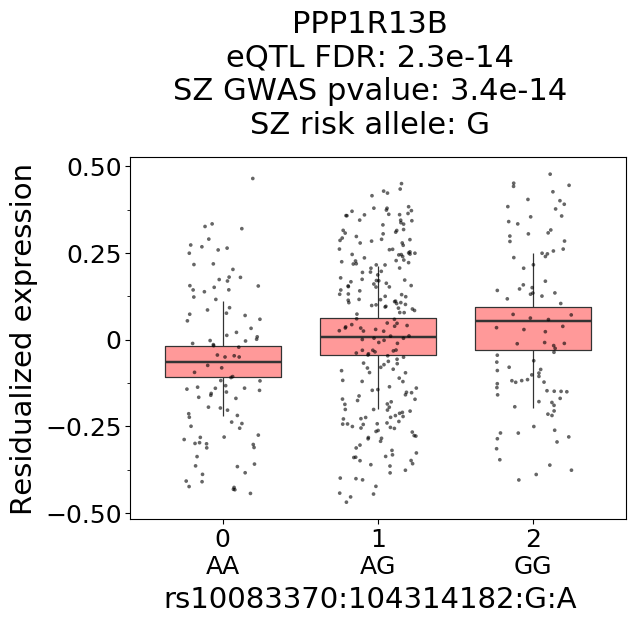

<ggplot: (8774011244427)>
top_3_eqtl_in_gwas_significant_index_snps_caudate 3 rs7432375 ENSG00000114054.13


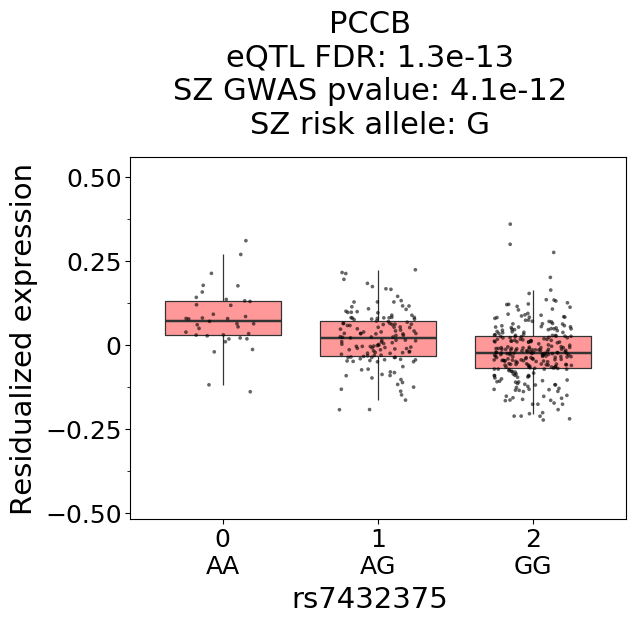

<ggplot: (8774011227064)>
top_4_eqtl_in_gwas_significant_index_snps_caudate 4 rs2949006:200715388:T:G ENSG00000162971.10


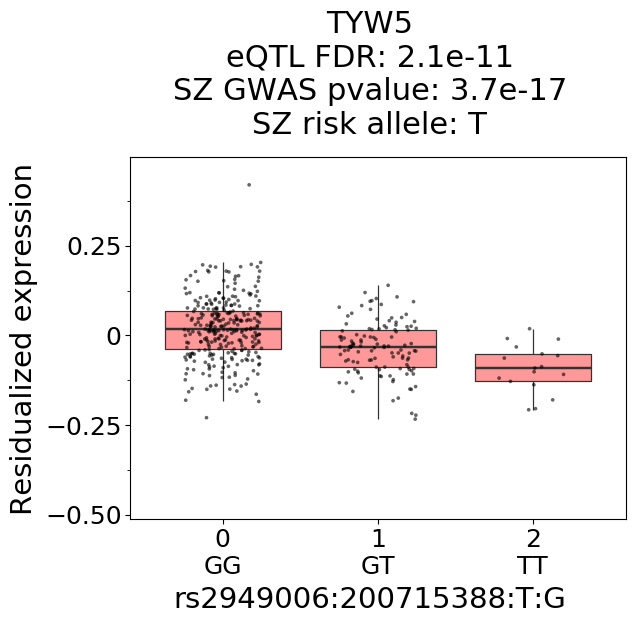

<ggplot: (8774011289631)>
top_5_eqtl_in_gwas_significant_index_snps_caudate 5 rs1080500 ENSG00000163938.16


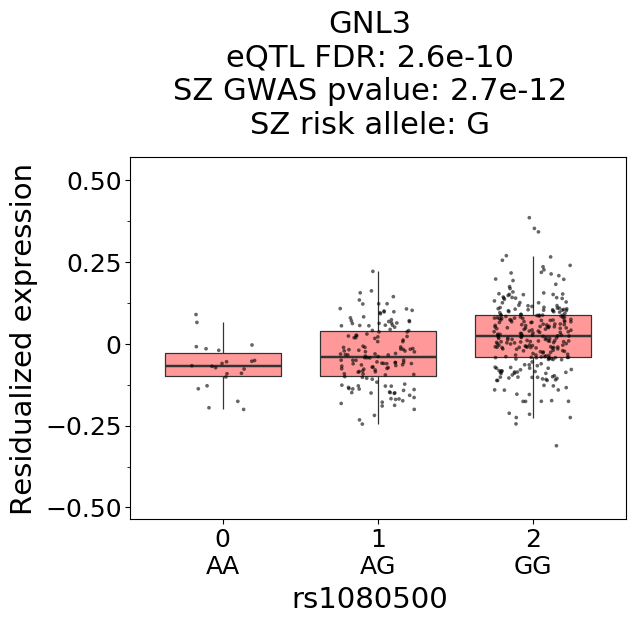

<ggplot: (8774445377112)>
top_6_eqtl_in_gwas_significant_index_snps_caudate 6 rs704373:63867355:A:G ENSG00000163634.11


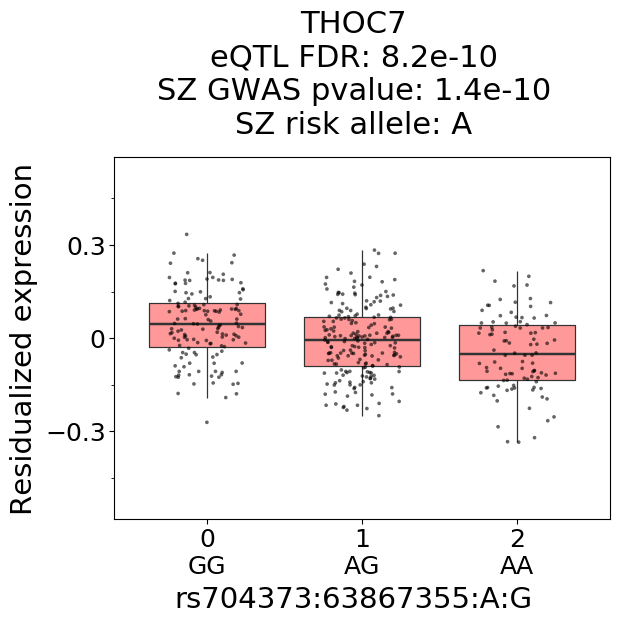

<ggplot: (8774446039507)>
top_7_eqtl_in_gwas_significant_index_snps_caudate 7 rs4925114 ENSG00000175662.17


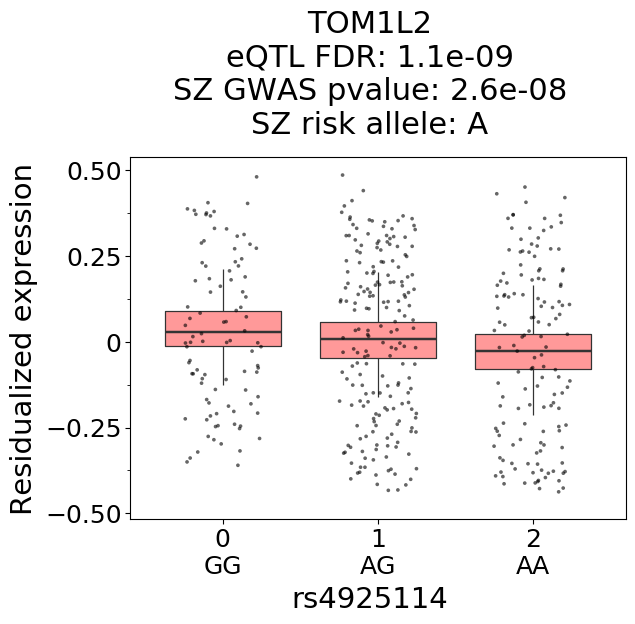

<ggplot: (8774445385328)>
top_8_eqtl_in_gwas_significant_index_snps_caudate 8 rs35774874:130811356:T:C ENSG00000120451.10


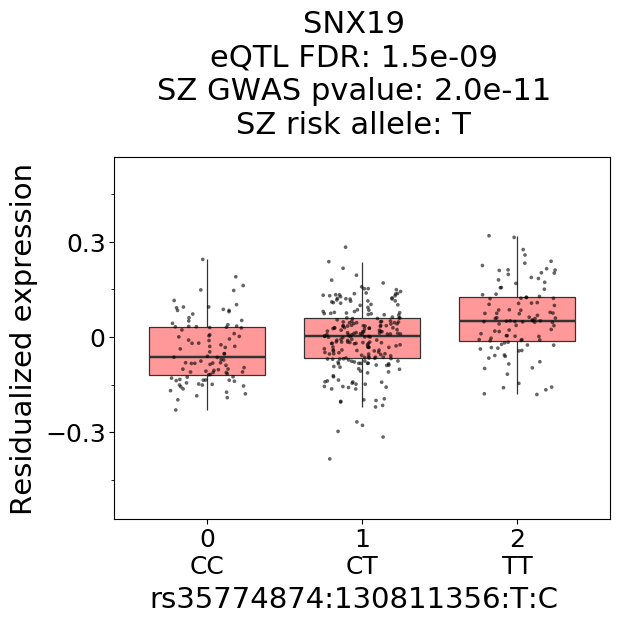

<ggplot: (8774445288828)>
top_9_eqtl_in_gwas_significant_index_snps_caudate 9 rs7216638:2156453:T:A ENSG00000167720.12


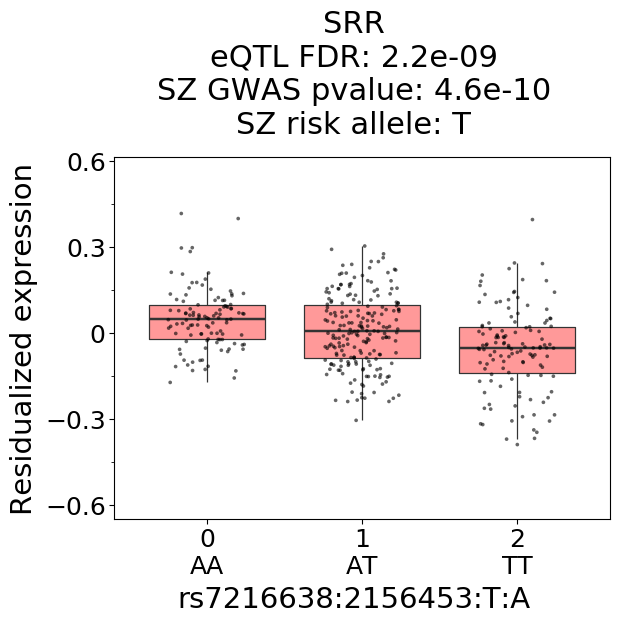

<ggplot: (8774445594781)>


In [25]:
top10 = top_gwas_eqtl_df.sort_values('p-value', ascending=True).groupby('gene').first().sort_values('p-value').head(10).reset_index()
for x  in top10.itertuples():
    filename = "top_%d_eqtl_in_gwas_significant_index_snps_caudate" % x.Index
    p = gwas_annotated_eqtl_plot(x.SNP, x.gene)
    print(filename, x.Index, x.SNP, x.gene)
    print(p)
    save_plot(p, filename)

# eQTL for top GWAS index SNP

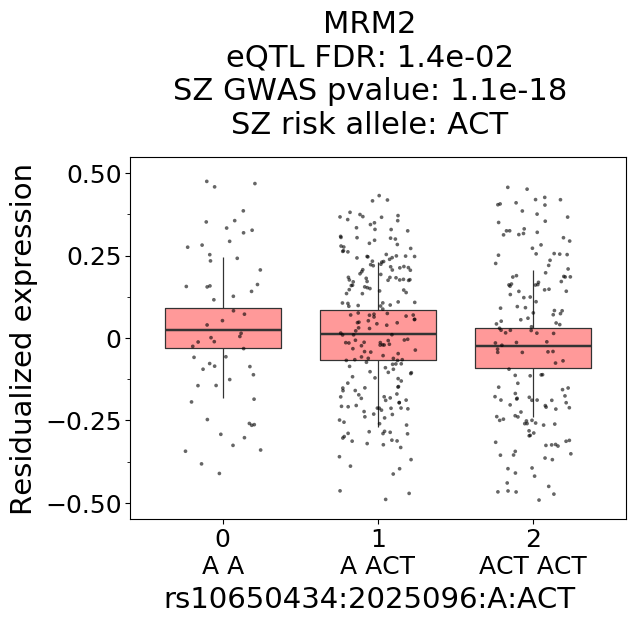

<ggplot: (8774445352271)>

In [26]:
a = top_gwas_eqtl_df.sort_values(['P', 'FDR'])
p = gwas_annotated_eqtl_plot(a.iloc[0]['SNP'], a.iloc[0]['gene'])
save_plot(p, 'eqtl_for_top_index_snp_caudate')
p

# CACNA1I

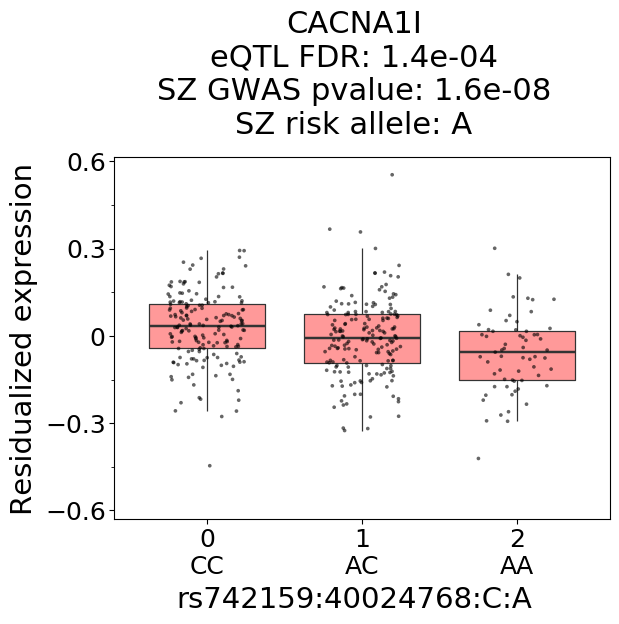

<ggplot: (8774445398336)>

In [27]:
p = gwas_annotated_eqtl_plot('rs742159:40024768:C:A', gene_id_from_symbol('CACNA1I'))
save_plot(p, 'CACNA1I_eqtl_caudate')
p

# DRD2

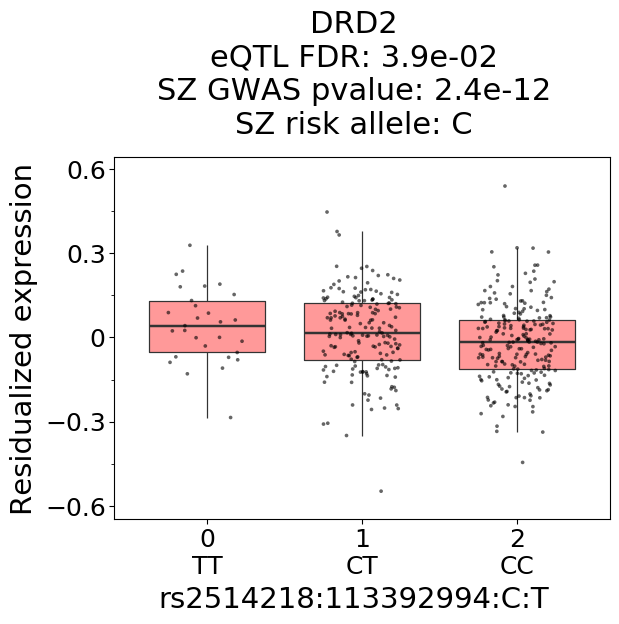

<ggplot: (8774445222220)>

In [28]:
p = gwas_annotated_eqtl_plot('rs2514218:113392994:C:T', gene_id_from_symbol('DRD2'))
save_plot(p, 'DRD2_eqtl_caudate')
p